In [3]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
# 加载 EMG 数据
data_Dir = "/home/admin123/SATData/data"
# peopleList = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17']
peopleList = ['S01']
exp_class = "MJ" # 单关节

exp_index = "T1"
people_index = 'S01'


allEmgData = []
allAngleData = []
dataSegFlags = []

for people_index in peopleList:
    expList = os.listdir(os.path.join(data_Dir, people_index, exp_class))
    for exp_index in expList:
        dataDirPath = os.path.join(data_Dir, people_index, exp_class, exp_index)
        emgDataPath = os.path.join(dataDirPath, "emgFilt.csv")
        angleDataPath = os.path.join(dataDirPath, "humanPositions.csv")
        emgDataArray = pd.read_csv(emgDataPath).to_numpy()
        angleDataArray = pd.read_csv(angleDataPath).to_numpy()
        emgDataArray = emgDataArray[:,1:]
        angleDataArray = angleDataArray[:,1:4]*180/np.pi
        allEmgData.append(emgDataArray)
        allAngleData.append(angleDataArray)
        dataSegFlags.append(len(emgDataArray))

# 将所有 emgDataArray 垂直拼接在一起
if allEmgData:  # 确保列表不为空
    final_emg_data = np.concatenate(allEmgData, axis=0)
    print("最终拼接后的形状:", final_emg_data.shape)
else:
    print("没有找到有效的 emgDataArray，无法拼接。")

# 将所有 angleDataArray 垂直拼接在一起
if allEmgData:  # 确保列表不为空
    final_angle_data = np.concatenate(allAngleData, axis=0)
    print("最终拼接后的形状:", final_angle_data.shape)
else:
    print("没有找到有效的 allEmgData，无法拼接。")

最终拼接后的形状: (29405, 12)
最终拼接后的形状: (29405, 3)


In [5]:
# 计算协方差矩阵
final_emg_data_T = final_emg_data.T
covMatrix = np.cov(final_emg_data_T)
print("covMatrix.shape = ",covMatrix.shape)

covMatrix.shape =  (12, 12)


In [6]:
# 计算相关系数
correlationMatrix = np.zeros((12,12))
for i in range(len(covMatrix)):
    for j in range(len(covMatrix[0])):
        correlationMatrix[i,j] = covMatrix[i,j] / (np.sqrt(covMatrix[i,i])*np.sqrt(covMatrix[j,j]))
correlationMatrix = np.round(correlationMatrix, 2)
print("correlationMatrix.shape = ", correlationMatrix.shape)
print(correlationMatrix)

correlationMatrix.shape =  (12, 12)
[[ 1.    0.82  0.17  0.16  0.54  0.43  0.68  0.1   0.35  0.06 -0.25 -0.28]
 [ 0.82  1.    0.55 -0.06  0.61  0.65  0.9   0.23  0.18 -0.09 -0.35 -0.36]
 [ 0.17  0.55  1.   -0.32  0.36  0.59  0.59  0.22 -0.19 -0.29 -0.31 -0.25]
 [ 0.16 -0.06 -0.32  1.    0.05 -0.11 -0.12  0.03  0.44  0.53  0.33  0.32]
 [ 0.54  0.61  0.36  0.05  1.    0.58  0.57  0.21  0.15  0.01 -0.18 -0.16]
 [ 0.43  0.65  0.59 -0.11  0.58  1.    0.71  0.63 -0.09 -0.09 -0.28 -0.25]
 [ 0.68  0.9   0.59 -0.12  0.57  0.71  1.    0.4   0.15 -0.06 -0.25 -0.29]
 [ 0.1   0.23  0.22  0.03  0.21  0.63  0.4   1.   -0.    0.11  0.1   0.1 ]
 [ 0.35  0.18 -0.19  0.44  0.15 -0.09  0.15 -0.    1.    0.66  0.53  0.48]
 [ 0.06 -0.09 -0.29  0.53  0.01 -0.09 -0.06  0.11  0.66  1.    0.66  0.64]
 [-0.25 -0.35 -0.31  0.33 -0.18 -0.28 -0.25  0.1   0.53  0.66  1.    0.91]
 [-0.28 -0.36 -0.25  0.32 -0.16 -0.25 -0.29  0.1   0.48  0.64  0.91  1.  ]]


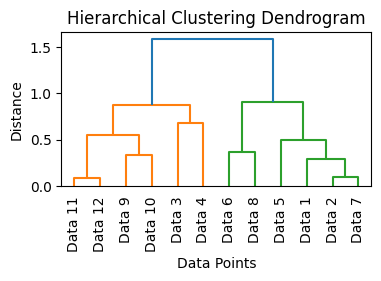

Data 1 is in cluster 6
Data 2 is in cluster 6
Data 3 is in cluster 3
Data 4 is in cluster 4
Data 5 is in cluster 6
Data 6 is in cluster 5
Data 7 is in cluster 6
Data 8 is in cluster 5
Data 9 is in cluster 2
Data 10 is in cluster 2
Data 11 is in cluster 1
Data 12 is in cluster 1


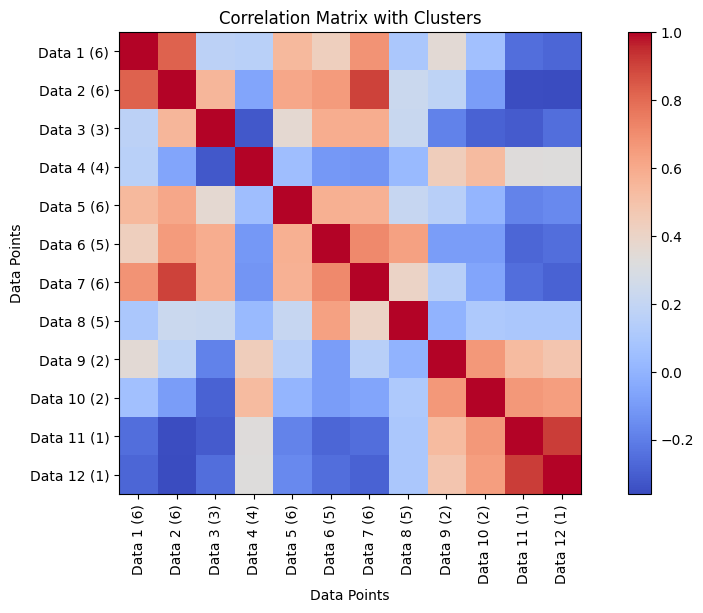

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# 根据相关性矩阵聚类
cluster_num = 6

# 将相关性矩阵转换为距离矩阵
distanceMatrix = 1 - np.abs(correlationMatrix)

# 将距离矩阵转换为 condensed 形式
condensedDistanceMatrix = squareform(distanceMatrix)

# 使用层次聚类
Z = linkage(condensedDistanceMatrix, method='ward')

# 绘制树状图
plt.figure(figsize=(4, 2))
dendrogram(Z, labels=[f'Data {i+1}' for i in range(12)], 
           leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# 假设我们选择3个聚类
clusters = fcluster(Z, t=cluster_num, criterion='maxclust')

# 输出聚类结果
for i, cluster in enumerate(clusters):
    print(f'Data {i+1} is in cluster {cluster}')

# 可视化聚类结果
plt.figure(figsize=(12, 6))
plt.imshow(correlationMatrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix with Clusters')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.xticks(range(12), [f'Data {i+1} ({clusters[i]})' for i in range(12)], rotation=90)
plt.yticks(range(12), [f'Data {i+1} ({clusters[i]})' for i in range(12)])
plt.show()

In [8]:
# 根据聚类结果将数据分群
afterClusterEmgIndex = []
for i in range(cluster_num):
    emgIndexGroup = []
    for j in range(len(clusters)):
        if clusters[j] == i+1:
            emgIndexGroup.append(j+1)
    afterClusterEmgIndex.append(emgIndexGroup)

print("聚类结果", afterClusterEmgIndex)

聚类结果 [[11, 12], [9, 10], [3], [4], [6, 8], [1, 2, 5, 7]]


In [10]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

# KPCA 算法实现
def KPCA_func(data):
    # 标准化数据
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    # 初始化KPCA
    kpca = KernelPCA(n_components=1, kernel='rbf', gamma=15)

    # 应用KPCA
    X_kpca = kpca.fit_transform(X_scaled)
    return X_kpca

def PCA_func(data):
    # 标准化数据
    scaler = StandardScaler()
    X_std = scaler.fit_transform(data)

    # 初始化PCA
    pca = PCA(n_components=1)
    X_pca = pca.fit_transform(X_std)
    return X_pca

def WA_func(data):
    
    return np.mean(data, axis=1, keepdims=True)

In [13]:

# 数据融合
fusionMethod = "NNWA"

if fusionMethod != "NNWA":
    mergedEmgData = []
    for i in afterClusterEmgIndex:
        subEmgData = final_emg_data[:,np.array(i)-1]
        if fusionMethod == "KPCA":
            subMergedEmgData = KPCA_func(subEmgData)

        elif fusionMethod == "PCA":
            subMergedEmgData = PCA_func(subEmgData)

        elif fusionMethod == "WA":
            subMergedEmgData = WA_func(subEmgData)
        
        mergedEmgData.append(subMergedEmgData)
        print(subMergedEmgData.shape)
    finalMergedEmgData = np.concatenate(mergedEmgData, axis=1)
else:
    finalMergedEmgData = final_emg_data
    
print(finalMergedEmgData.shape)

(29405, 12)


In [14]:
# 制作训练用的数据集

# 数据集参数
windowLength = 256
stepLength = 1
delta_T = 20
Length = windowLength + delta_T

finalMergedEmgData_T = finalMergedEmgData.T
finalAngleData_T = final_angle_data.T
startIndex = 0

emgList = []
angleList = []

for dataFlag in dataSegFlags:
    singleExpEmgData = finalMergedEmgData_T[:, startIndex:startIndex+dataFlag]
    singleExpAngleData = finalAngleData_T[:,startIndex:startIndex+dataFlag]
    startIndex += dataFlag
    length = np.floor((len(singleExpEmgData[0])-Length/stepLength))
    for j in range(int(length)):
        semgSample = singleExpEmgData[:, stepLength*j:(windowLength+stepLength*j)]
        angleSample = singleExpAngleData[:, Length+stepLength*j]
        emgList.append(semgSample)
        angleList.append(angleSample)

emg = np.array(emgList)
angle = np.array(angleList)
print(emg.shape)
print(angle.shape)

(26645, 12, 256)
(26645, 3)
